# Word2vec preprocessing

Preprocessing is not the most interesting part of NLP, but it is still one of the most important ones. Your task is to preprocess raw text (you can use your own, or [this one](http://mattmahoney.net/dc/textdata). For this task text preprocessing mostly consists of:

1. cleaning (mostly, if your dataset is from social media or parced from the internet)
1. tokenization
1. building the vocabulary and choosing its size
1. assigning each token a number (numericalization)
1. data structuring and batching

Your goal is to make SkipGramBatcher class which returns two numpy tensors with word indices. You can implement batcher for Skip-Gram or CBOW architecture, the picture below can be helpfull to remember the difference.

![text](https://raw.githubusercontent.com/deepmipt/deep-nlp-seminars/651804899d05b96fc72b9474404fab330365ca09/seminar_02/pics/architecture.png)

There are several ways to do it right. Shapes could be `(batch_size, 2*window_size)`, `(batch_size,)` for CBOW or `(batch_size,)`, `(batch_size,)` for Skip-Gram. You should **not** do negative sampling here.

They should be adequately parametrized: CBOW(batch_size, window_size, ...), SkipGram(num_skips, skip_window). You should implement only one batcher in this task, it's up to you which one to chose.

Useful links:
1. [Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
1. [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
1. [Distributed Representations of Words and Phrases and their Compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

You can write the code in this notebook, or in separate file. It will be reused for the next task. Result of your work should represent that your batch have proper structure (right shapes) and content (words should be from one context, not some random indices). To show that, translate indices back to words and print them to show something like this:

```
bag_window = 2

batch = [['first', 'used', 'early', 'working'],
        ['used', 'against', 'working', 'class'],
        ['against', 'early', 'class', 'radicals'],
        ['early', 'working', 'radicals', 'including']]

labels = ['against', 'early', 'working', 'class']
```

If you struggle with somethng, ask your neighbour. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - just do it! Good luck!

In [1]:
from pathlib import Path
from collections import Counter
from itertools import islice, product, chain

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
DATA_PATH = Path('../data')

In [46]:
class SkipGramBatcher():
    def __init__(self, text):
        self.text = text
    
    @classmethod
    def from_file(cls, file_path):
        with open(file_path) as f:
            text = f.read()
        
        return cls(text)
    
    def _tokenize(self):
        self.tokens = self.text.split()
    
    def _count_tokens(self):
        self.token_counts = Counter(self.tokens)
    
    def _build_vocab(self, cutoff):
        self.token_counts = dict(filter(lambda x: x[1] >= cutoff, self.token_counts.items()))
        self.token_to_idx = {token:idx for (idx, (token, _)) in enumerate(self.token_counts.items())}
        self.idx_to_token = {idx:token for (token, idx) in self.token_to_idx.items()}
        self.vocab = set(self.token_to_idx)

    def _filter_tokens(self):
        self.tokens = [token for token in self.tokens if token in self.vocab]
    
    def _vectorize_tokens(self):
        self.vectorized_tokens = [self.token_to_idx[token] for token in self.tokens]
        
    def devectorize_tokens(self, indices):
        return [self.idx_to_token[idx] for idx in indices]
        
    def prepare_data(self, cutoff=1):
        self._tokenize()
        self._count_tokens()
        self._build_vocab(cutoff)
        self._filter_tokens()
        self._vectorize_tokens()
    
    def _create_sliding_window(self, window_size):
        tokens_size = len(self.tokens)

        for i in range(0, tokens_size):
            # window_size = np.random.randint(1, max_window_size+1)

            center_word = islice(self.vectorized_tokens, i, i + 1)
            left_context = islice(self.vectorized_tokens, i + 1, 
                                  min(tokens_size, i + window_size + 1))
            right_context = islice(self.vectorized_tokens, 
                                   max(0, i - window_size), i)
            yield from product(center_word, chain(left_context, right_context))
            
    def generate_batches(self, window_size=1, batch_size=1, drop_last=True):
        window = self._create_sliding_window(window_size)
        batch = list(zip(*islice(window, batch_size)))
        x_batch, labels_batch = np.array(batch[0]), np.array(batch[1])

        if drop_last:
            while batch and len(batch[0]) == batch_size:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = np.array(batch[0]), np.array(batch[1])
        else:
            while batch:
                yield x_batch, labels_batch
                batch = list(zip(*islice(window, batch_size)))
                x_batch, labels_batch = np.array(batch[0]), np.array(batch[1])

In [66]:
sg_batcher = SkipGramBatcher.from_file(DATA_PATH/'text8')
sg_batcher.prepare_data(cutoff=10)

window_size = 3
batch_size = 10

g = sg_batcher.generate_batches(window_size=window_size, batch_size=batch_size)
x_batch, labels_batch = next(g)

x_tokens_batch = sg_batcher.devectorize_tokens(x_batch)
labels_tokens_batch = sg_batcher.devectorize_tokens(labels_batch)

print('\nFirst original words in text: ')
print(' '.join(sg_batcher.text.split()[:batch_size]))

print('\nFirst pre-processed tokens:')
print(sg_batcher.tokens[:batch_size])

print('\nFirst vectorized tokens:')
print(sg_batcher.vectorized_tokens[:batch_size])

print('\nToken-index mapping:')
print(list(sg_batcher.token_to_idx.items())[:batch_size])

print('\nWindow size:')
print(window_size)

print('\nBatch size:')
print(batch_size)

print('\nBatch x indices:')
print(repr(x_batch))

print('\nBatch x tokens:')
print(x_tokens_batch)

print('\nBatch labels indices:')
print(repr(labels_batch))

print('\nBatch labels tokens:')
print(labels_tokens_batch)

print('\nBatch pairs indices:')
print(list(zip(x_batch, labels_batch)))

print('\nBatch pairs tokens:')
print(list(zip(x_tokens_batch, labels_tokens_batch)))


First original words in text: 
anarchism originated as a term of abuse first used against

First pre-processed tokens:
['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

First vectorized tokens:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Token-index mapping:
[('anarchism', 0), ('originated', 1), ('as', 2), ('a', 3), ('term', 4), ('of', 5), ('abuse', 6), ('first', 7), ('used', 8), ('against', 9)]

Window size:
3

Batch size:
10

Batch x indices:
array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2])

Batch x tokens:
['anarchism', 'anarchism', 'anarchism', 'originated', 'originated', 'originated', 'originated', 'as', 'as', 'as']

Batch labels indices:
array([1, 2, 3, 2, 3, 4, 0, 3, 4, 5])

Batch labels tokens:
['originated', 'as', 'a', 'as', 'a', 'term', 'anarchism', 'a', 'term', 'of']

Batch pairs indices:
[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (1, 4), (1, 0), (2, 3), (2, 4), (2, 5)]

Batch pairs tokens:
[('anarchism', 'originated'), ('anarchism', 'as'), ('anarchism', 'a'

In [10]:
token_counts_df = pd.DataFrame(token_counts, columns=['token', 'count'])
token_counts_df.head()

,token,count
0,the,1061396
1,of,593677
2,and,416629
3,one,411764
4,in,372201


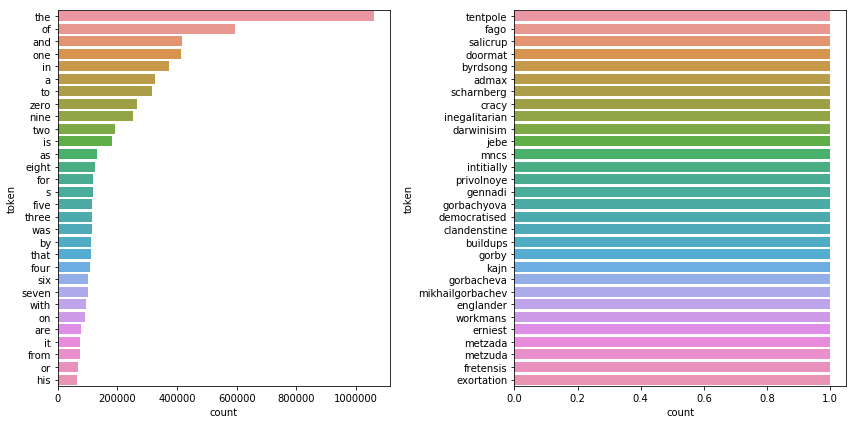

In [11]:
n = 30

fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=False)
sns.barplot(x='count', y='token', data=token_counts_df[:n], ax=axes[0])
sns.barplot(x='count', y='token', data=token_counts_df[-n:], ax=axes[1])
plt.tight_layout()

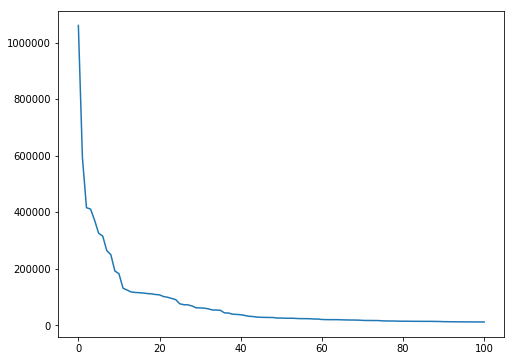

In [12]:
n = 100

fig, axes = plt.subplots(figsize=(8, 6))
plt.plot(token_counts_df.loc[:n, 'count'])